### Crap predefing

In [59]:
# Torch
import torch
import torch.nn as nn
from torch.autograd import Variable

# Utils
import string
import random
import re
import glob
import os
from PIL import Image

# Torchvision
import torchvision.models as models
import torchvision.transforms as transforms

# Predef constants
all_letters = string.ascii_letters
n_letters = len(all_letters) + 2 # Plus EOS marker and STOES
EOS = n_letters - 1
STOS = n_letters - 2

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

input_image_size =  512* 7* 7



In [165]:
# Heavy veriables 
extractor = models.vgg16(pretrained=True).features
if use_cuda:
    extractor = extractor.cuda()
train_images = torch.load('train_image')

In [161]:
loader = transforms.Compose([
    transforms.ToTensor()])  # transform it into a torch tensor

import PIL.Image
def image_loader(image_name):
    image = PIL.Image.open(image_name)
    image = Variable(loader(image)).type(dtype)
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image



In [62]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_image_size + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_image_size + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()
        
        if use_cuda:
            self.i2h = self.i2h.cuda()
            self.i2o = self.i2o.cuda()
            self.o2o = self.o2o.cuda()
    
    def forward(self, image, input, hidden):
        input_combined = Variable(torch.cat([image.data, input.data, hidden.data], 1))
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size)).type(dtype)

In [94]:
def image_tensor(img):
    return Variable(extractor(img))


# One-hot matrix of first to last letters with STOS (not including EOS) for input
def make_chars_input(chars):
    tensor = torch.zeros(len(chars) + 1, n_letters)
    tensor[0][-2] = 1
    for ci in range(len(chars)):
        char = chars[ci]
        tensor[ci+1][all_letters.find(char)] = 1
    tensor = tensor.view(-1, 1, n_letters)
    return Variable(tensor).type(dtype)

def make_target(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.insert(0, STOS)
    letter_indexes.append(EOS) # EOS
    tensor = torch.FloatTensor(letter_indexes)
    return Variable(tensor).type(dtype)

def generate_random_sample():
    train_samples = glob.glob(os.getcwd() + "\datagen\\data\\train\\*")
    
    
    image_path = random.choice(train_samples)
    idx = train_samples.index(image_path)
    image_name_cut = image_path.split("\\")[-1]
    
    word = image_name_cut.split("_")[0]
    
    image_input = Variable(train_images[idx].unsqueeze(0)).type(dtype)
    
    line_target = make_target(word)
    line_input = make_chars_input(word)
    
    return image_input, line_input, line_target


generate_random_sample()
print()

In [137]:
def train(image_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(image_tensor, input_line_tensor[i], hidden)
        hidden = hidden.cuda()
        loss += criterion(output, target_line_tensor[i].type(torch.cuda.LongTensor))
    
    loss.backward()
    optimizer.step()
    return output, loss.data[0] / input_line_tensor.size()[0]

In [ ]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [201]:
from IPython.display import clear_output
from tqdm import tqdm
from tensorboardX import SummaryWriter
writer = SummaryWriter('logs')

n_epochs = 5000
print_every = 500
plot_every = 100
all_losses = []
loss_avg = 0 # Zero every plot_every epochs to keep a running average
learning_rate = 0.00001

rnn = RNN(n_letters, 128, n_letters)
if use_cuda:
    rnn = rnn.cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

start = time.time()
print("Loading")
rnn.load_state_dict(torch.load('LinearRnn.pt'))
print("Training")

best_loss = 100
best_state = None

for epoch in range(1, n_epochs + 1):
    output, loss = train(*generate_random_sample())
    loss_avg += loss

    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
    
    
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        writer.add_scalar('Train/Loss', loss_avg / plot_every, epoch)
        
        if loss_avg / plot_every < best_loss:
            best_state = rnn.state_dict()
            best_loss = loss_avg / plot_every
            
        loss_avg = 0


if best_state is not None:
    print("Saving")
    torch.save(rnn.state_dict(), "LinearRnn.pt")
    print("Done")
print("Best loss", best_loss)

Loading
Training
0m 27s (500 10%) 1.0250
0m 55s (1000 20%) 1.1297
1m 23s (1500 30%) 1.3920
1m 52s (2000 40%) 1.3010
2m 19s (2500 50%) 0.4151
2m 47s (3000 60%) 1.3461
3m 15s (3500 70%) 0.6292
3m 42s (4000 80%) 1.2642
4m 9s (4500 90%) 1.9305
4m 37s (5000 100%) 0.2199
Saving
Done
Best loss 0.9469225222156161


In [93]:
def make_char_input(chars):
    tensor = torch.zeros(len(chars), n_letters)
    for ci in range(len(chars)):
        char = chars[ci]
        tensor[ci+1][all_letters.find(char)] = 1
    tensor = tensor.view(-1, 1, n_letters)
    return Variable(tensor).type(dtype)

In [157]:


from tqdm import tqdm
def run_():
    train_samples = glob.glob(os.getcwd() + "\datagen\\data\\train\\*")
    
    image_tensors = torch.LongTensor(len(train_samples), input_image_size)
    
    for i in tqdm(range(len(train_samples))):
        image_path = train_samples[i]

        image_name_cut = image_path.split("\\")[-1]

        word = image_name_cut.split("_")[0]

        image_input = extractor(image_loader(os.getcwd() + "/datagen/data/train/" + image_name_cut))
        image_input.data = image_input.data.squeeze(0)
        image_input.data = image_input.data.view(image_input.data.size(0), -1)
        image_input.data =  image_input.data.view(1, -1).squeeze(0)
        image_tensors[i] = image_input.data
    torch.save(image_tensors, 'train_image')

In [163]:
run_()


  0%|          | 23/5500 [00:01<04:58, 18.32it/s]
Exception in thread Thread-42:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 5500/5500 [00:51<00:00, 107.43it/s]


In [116]:
def generate_one(image, temperature=0.5):
    image_input = Variable(train_images[idx].unsqueeze(0)).type(dtype)
    
    chars_input = torch.zeros(1, n_letters)
    chars_input[0][-2] = 1
    chars_input = Variable(chars_input).type(dtype)
    
    hidden = rnn.init_hidden()

    output_str = ""
    
    max_length = 12
    
    for i in range(max_length):
        output, hidden = rnn(image_input, chars_input, hidden)
        
        # Sample as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Stop at EOS, or add to output_str
        if top_i == EOS:
            break
        if top_i == STOS:
            continue
        else:
            
            char = all_letters[top_i]
            output_str += char
            chars_input = torch.zeros(1, n_letters)
            chars_input[0][top_i] = 1
            chars_input = Variable(chars_input).type(dtype)
            
            
    return output_str


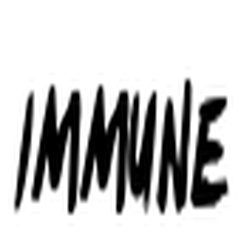

atlatt immune


In [212]:
from IPython.core.display import Image, display

train_samples = glob.glob(os.getcwd() + "\datagen\\data\\test\\*")
image_path = random.choice(train_samples)
idx = train_samples.index(image_path)
image_name_cut = image_path.split("\\")[-1]
word = image_name_cut.split("_")[0]
image_input = Variable(train_images[idx].unsqueeze(0)).type(dtype)

display(Image(image_path))

print(generate_one(image_input), word)